# **Logistic Regression, Random Forest, or KNN**

_John Andrew Dixon_

---

**Setup**

In [411]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from IPython.display import clear_output

In [397]:
# Remote url to the dataset
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTvYsiM0huszmpSKoHmkPURxSeCGxnCL0dPSMngtc_ij2E3jXgsd7Cqj4c6zxauMqYyEQWIcwo9X1hd/pub?output=csv"
# Load the dataset
df = pd.read_csv(url)
# Verify it loaded by viewing info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [398]:
def classifier_metrics(classifier_name, train_pred, train_true, test_pred, test_true, verbose=True):
    """Function that outputs classifier metrics for a specific classifier"""
    indices = ["Train Accuracy", "Test Accuracy", "Train Recall", "Test Recall", "Train Precision", "Test Precision"]
    metrics_df = pd.DataFrame(columns=[classifier_name], index=indices)

    metrics_df.iloc[0, 0] = accuracy_score(train_true, train_pred)
    metrics_df.iloc[1, 0] = accuracy_score(test_true, test_pred)
    metrics_df.iloc[2, 0] = recall_score(train_true, train_pred, zero_division=0)
    metrics_df.iloc[3, 0] = recall_score(test_true, test_pred, zero_division=0)
    metrics_df.iloc[4, 0] = precision_score(train_true, train_pred, zero_division=0)
    metrics_df.iloc[5, 0] = precision_score(test_true, test_pred, zero_division=0)
    if verbose:
        ConfusionMatrixDisplay.from_predictions(
            test_true,
            test_pred,
            cmap="Reds"
        );
    return metrics_df

---

## **Tasks**

### **Logistic Regression**

#### Default

For this dataset, we are dealing with malignant tumor diagnosis. A positive means the patient is diagnosed with a malignant, cancerous tumor. A negative means the patient is diagnoses with a benign, non-cancerous tumor.

In [399]:
# DataFrame of models tried
models = pd.DataFrame(index=["Train Accuracy", "Test Accuracy", "Train Recall", "Test Recall", "Train Precision", "Test Precision"])

In [400]:
# Create the feature matrix
X = df.drop(columns=["id", "diagnosis"])
# Create the target vector
y = df["diagnosis"].replace({"B": 0, "M": 1})
# Create the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [401]:
# Create a standard scaler
scaler = StandardScaler()
# Create a logistic regression model
lor = LogisticRegression(random_state=42)
# Create a logistic regression pipeline
lor_pipeline = make_pipeline(scaler, lor)

,LogisticRegression Default
Train Accuracy,0.985915
Test Accuracy,0.979021
Train Recall,0.974684
Test Recall,0.981481
Train Precision,0.987179
Test Precision,0.963636


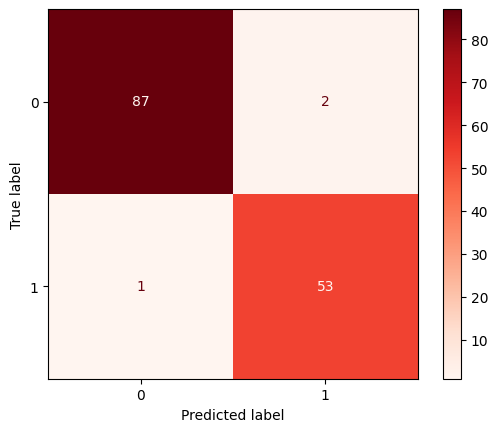

In [402]:
# Fit log reg pipe to training data
lor_pipeline.fit(X_train, y_train)
# Get predictions with log reg pipe
train_pred = lor_pipeline.predict(X_train)
test_pred = lor_pipeline.predict(X_test)
models = pd.concat([models, classifier_metrics("LogisticRegression Default", train_pred, y_train, test_pred, y_test)], axis=1)
models

#### **Tuning L1 _and_ L2**

In [403]:
# Create hyperparameter values to iterate through
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratios = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
# Create a DataFrame to add all possible values
cols = ["Train Accuracy", "Test Accuracy", "Train Recall", "Test Recall", "Train Precision", "Test Precision"]
log_reg_tunings = pd.DataFrame(columns=cols)

In [404]:
# Loop through the hyperparameters
for c in c_values:
    for ratio in l1_ratios:
        # Instantiate the Logistic Regression model, add to a pipeline and then fit the pipeline to a the training data
        log_reg = LogisticRegression(random_state=42, 
                                     penalty="elasticnet", 
                                     solver="saga", 
                                     max_iter=10000, 
                                     l1_ratio=ratio, 
                                     C=c,
                                     n_jobs=-1)
        log_reg_pipe = make_pipeline(scaler, log_reg)
        log_reg_pipe.fit(X_train, y_train)

        # Get predictions based on this specific tuning
        train_pred = log_reg_pipe.predict(X_train)
        test_pred = log_reg_pipe.predict(X_test)

        # Get the metrics and store into a temp dataframe
        m = classifier_metrics(f"c:{c}/ratio:{ratio}", train_pred, y_train, test_pred, y_test, verbose=False).T
        log_reg_tunings = pd.concat([log_reg_tunings, m])

In [405]:
log_reg_best = log_reg_tunings.sort_values(by=["Test Recall", "Test Precision"], ascending=False).head(1).T
log_reg_best = log_reg_best.set_axis(labels=["LogisticRegression Best"], axis="columns")
models = pd.concat([models, log_reg_best], axis="columns")
models

,LogisticRegression Default,LogisticRegression Best
Train Accuracy,0.985915,0.985915
Test Accuracy,0.979021,0.979021
Train Recall,0.974684,0.974684
Test Recall,0.981481,0.981481
Train Precision,0.987179,0.987179
Test Precision,0.963636,0.963636


### **KNN**

#### Default

In [406]:
# 1. Instantiate a knn classifier
# 2. Put it in a pipeline with a scaler
# 3. Fit the pipe to the training data
knn_classifier = KNeighborsClassifier(n_jobs=-1)
knn_pipe = make_pipeline(scaler, knn_classifier)
knn_pipe.fit(X_train, y_train)
# 1. Get predictions on the X-training data
# 2. Get predictions on the X_test data
train_pred = knn_pipe.predict(X_train)
test_pred = knn_pipe.predict(X_test)

,LogisticRegression Default,LogisticRegression Best,KNeighborsClassifier Default
Train Accuracy,0.985915,0.985915,0.978873
Test Accuracy,0.979021,0.979021,0.958042
Train Recall,0.974684,0.974684,0.943038
Test Recall,0.981481,0.981481,0.944444
Train Precision,0.987179,0.987179,1.0
Test Precision,0.963636,0.963636,0.944444


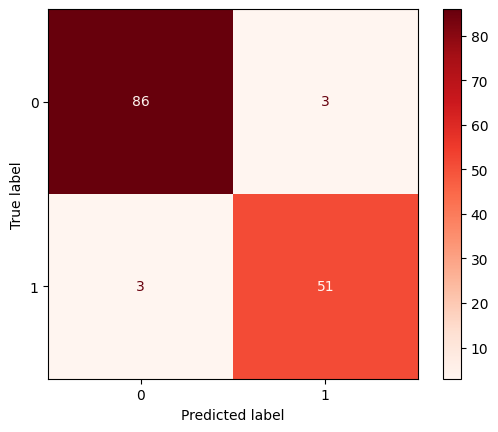

In [407]:
base_knn_metrics = classifier_metrics("KNeighborsClassifier Default", train_pred, y_train, test_pred, y_test)
models = pd.concat([models, base_knn_metrics], axis=1)
models

#### Tuning

In [408]:
# 1. Instantiate a KNN_pipe
# 2. See params
knn_pipe = make_pipeline(scaler, KNeighborsClassifier(n_jobs=-1))
knn_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(n_jobs=-1),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': -1,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In [409]:
# Create a param grid
param_grid = {
    "kneighborsclassifier__n_neighbors": [number for number in range(1, 51)],
    "kneighborsclassifier__weights": ["uniform", "distance"],
    "kneighborsclassifier__p": [1, 2, 3, 4, 5]
}

# 1. Instantiate a GridSearch object
# 2. Fit the GridSearch Object to the training data
# 3. Get the best params out to see what they are
knn_pipe_grid = GridSearchCV(knn_pipe, param_grid, scoring=("recall", "precision"), refit="recall")
knn_pipe_grid.fit(X_train, y_train)
knn_pipe_grid.best_params_


{'kneighborsclassifier__n_neighbors': 3,
 'kneighborsclassifier__p': 1,
 'kneighborsclassifier__weights': 'uniform'}

,LogisticRegression Default,LogisticRegression Best,KNeighborsClassifier Default,KNeighborsClassifier Best
Train Accuracy,0.985915,0.985915,0.978873,0.99061
Test Accuracy,0.979021,0.979021,0.958042,0.972028
Train Recall,0.974684,0.974684,0.943038,0.974684
Test Recall,0.981481,0.981481,0.944444,0.962963
Train Precision,0.987179,0.987179,1.0,1.0
Test Precision,0.963636,0.963636,0.944444,0.962963


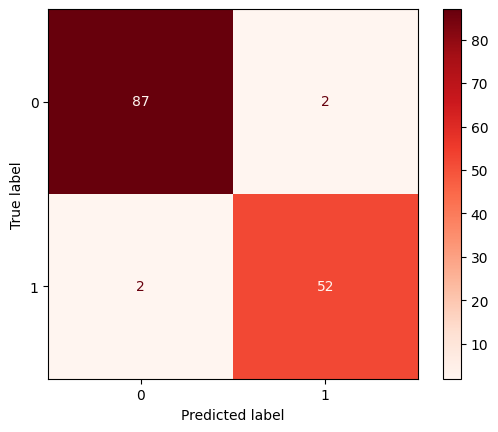

In [410]:
# 1. Grab the best estimator/mode from the GridSearch object
# 2. Use it to predict with train and test data
best_knn = knn_pipe_grid.best_estimator_
train_pred = best_knn.predict(X_train)
test_pred = best_knn.predict(X_test)
# 1. Get the metrics of the best estimator
# 2. Add it to the models dataframe for comparison
best_knn_metrics = classifier_metrics("KNeighborsClassifier Best", train_pred, y_train, test_pred, y_test)
models = pd.concat([models, best_knn_metrics], axis=1)
models

### **Random Forest**

#### Default

In [481]:
# 1. Create a Random Forest Classifier
# 2. Fit the forest to the training data
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)
# 1. Get training predictions from the forest
# 2. Get testing predictions from the forest
train_pred = random_forest.predict(X_train)
test_pred = random_forest.predict(X_test)

,LogisticRegression Default,LogisticRegression Best,KNeighborsClassifier Default,KNeighborsClassifier Best,RandomForestClassifier Base
Train Accuracy,0.985915,0.985915,0.978873,0.99061,1.0
Test Accuracy,0.979021,0.979021,0.958042,0.972028,0.965035
Train Recall,0.974684,0.974684,0.943038,0.974684,1.0
Test Recall,0.981481,0.981481,0.944444,0.962963,0.944444
Train Precision,0.987179,0.987179,1.0,1.0,1.0
Test Precision,0.963636,0.963636,0.944444,0.962963,0.962264


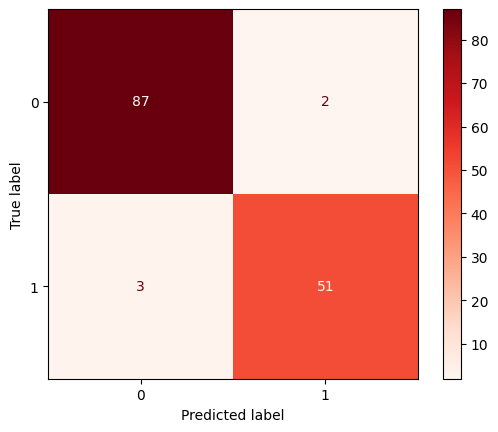

In [482]:
base_random_forest_metrics = classifier_metrics("RandomForestClassifier Base", train_pred, y_train, test_pred, y_test)
models = pd.concat([models, base_random_forest_metrics], axis=1)
models

#### Tuning